In [13]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import tensorflow.contrib.keras as keras
import os

import warnings
warnings.filterwarnings("ignore")

input_folder = "."

In [14]:
train_data  = pd.read_csv(os.path.join(input_folder, "train.csv"))
                          
train_images = train_data.iloc[:,1:].values
train_labels = train_data.iloc[:,:1].values    

print(train_images.shape, train_labels.shape)

(42000, 784) (42000, 1)


In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

#handy function to plot image with its label
def plot_image(images, labels, index):
    plt.imshow(images [index].reshape(28, 28), cmap="Greys", interpolation="None")
    plt.title(labels [index])

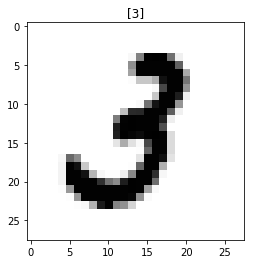

In [16]:
index = np.random.randint(0, train_labels.shape[0])
plot_image(train_images, train_labels, index)

In [17]:
#convert to one-hot vectors
def one_hot(labels, num_classes):
    y = np.zeros((labels.shape [0], num_classes))
    y [np.arange(labels.shape [0]), labels.flatten()] = 1
    
    return y

def prepare_images(images):
    inputs = images.astype(float)
    inputs -= 127.5
    inputs /= 127.5
    
    return inputs.reshape(-1, 28, 28, 1)

def train_validation_split(inputs, targets, ratio = 0.8):
    data_size = inputs.shape[0]
    p = np.random.permutation(data_size)
    
    train_size = int(data_size * ratio)    
    
    ti = p [:train_size]
    tv = p [train_size:]
    
    return inputs [ti], targets [ti], inputs [tv], targets [tv]

def random_batch(inputs, targets, size = 100):
    data_size = inputs.shape[0]
    p = np.random.permutation(data_size)
    
    i = p [:size]
    
    return inputs [i], targets [i]
    

In [18]:
from scipy.ndimage.interpolation import rotate
from scipy.ndimage.interpolation import shift
from scipy.misc import imresize

def crop_image(img, size):
    x = img.shape [0]
    
    start = x // 2 - (size // 2)
    end = start + size
    
    return img [start:end, start:end]    

def wiggle_image(img, angle_range = 20, transform_range = 10, scale_range = (1, 1.7)):
    new_img = img.reshape(28, 28)
    
    scale = np.random.uniform(*scale_range)    
    
    new_img = imresize(new_img, scale)
    
    angle = np.random.randint(-angle_range, angle_range)    
    new_img = rotate(new_img, angle, cval=-1, reshape=False)
    
    dx = np.random.randint(-transform_range, transform_range)
    dy = np.random.randint(-transform_range, transform_range)
    
    new_img = shift(new_img, (dx, dy), cval=-1)
    
    new_img = crop_image(new_img, 28)
    
    return new_img.reshape(28 * 28)

def wiggle_images(images):
    return np.array([wiggle_image(img) for img in images])

def gen_image_variants(train_images, train_labels, count=2):
    images = [None] * (count + 1)
    labels = [None] * (count + 1)
    
    for i in range(count):
        images [i] = wiggle_images(train_images)
        labels [i] = train_labels
        
    images [-1] = train_images
    labels [-1] = train_labels
    
    return np.concatenate(tuple(images)), np.concatenate(tuple(labels))

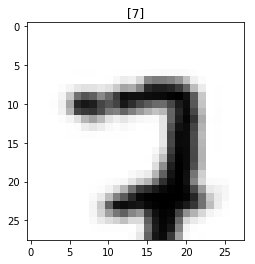

In [19]:
index = np.random.randint(0, train_images.shape [0])
img = wiggle_image(train_images [index])
plt.imshow(img.reshape(28,28), cmap="Greys", interpolation="None")
plt.title(train_labels[index])

In [20]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

def keras_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy, optimizer='adadelta', metrics=['accuracy'])
    
    return model

In [21]:
import time 

minutes = 60
hours = 60 * 60

def timed_train(images, labels, file_prefix = 'wm', train_time = 60):
    all_images, all_labels = gen_image_variants(images, labels)
    
    inputs = prepare_images(all_images)
    targets = one_hot(all_labels, 10)
    
    train_inputs, train_targets, validation_inputs, validation_targets = train_validation_split(inputs, targets)

    print("Train inputs:", train_inputs.shape, ", targets: ", train_targets.shape)
    print("Validation inputs:", validation_inputs.shape, ", targets: ", validation_targets.shape)
    print()
    
    model = keras_model()
    
    end = time.time() + train_time
    epochs = 0
    while time.time() < end:
        epochs += 1
        model.fit(train_inputs, train_targets, epochs=1, verbose=0)        
        model.save('model.tmp')
        
    loss, acc = model.evaluate(validation_inputs, validation_targets, verbose=0)
    
    file_name = '%s_acc_%d.h5' % (file_prefix, int(acc * 1000))
    model.save(file_name)
    
    print("Model with loss %.3f, acc %.3f saved to %s, total epochs: %d" % (loss, acc, file_name, epochs))      
    print()     
    

In [22]:
models_count = 3
time_per_model = 2 * minutes #5 * hours

for i in range(models_count):
    file_prefix = 'wm_%d' % (i + 1)
    timed_train(train_images, train_labels, file_prefix, time_per_model)
    
print("End.")

Train inputs: (100800, 28, 28, 1) , targets:  (100800, 10)
Validation inputs: (25200, 28, 28, 1) , targets:  (25200, 10)

Model with loss 0.596, acc 0.822 saved to wm_1_acc_822.h5, total epochs: 1

Train inputs: (100800, 28, 28, 1) , targets:  (100800, 10)
Validation inputs: (25200, 28, 28, 1) , targets:  (25200, 10)

Model with loss 0.553, acc 0.828 saved to wm_2_acc_828.h5, total epochs: 1

Train inputs: (100800, 28, 28, 1) , targets:  (100800, 10)
Validation inputs: (25200, 28, 28, 1) , targets:  (25200, 10)

Model with loss 0.550, acc 0.840 saved to wm_3_acc_840.h5, total epochs: 1

End.


Predicted: 3


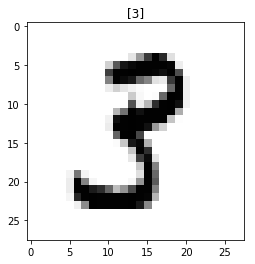

In [33]:
from keras.models import load_model

model = load_model('wm_2_acc_828.h5')
index = np.random.randint(0, train_images.shape [0])
input_data = prepare_images(train_images [index:index + 1])
p = np.argmax(model.predict(input_data))

print("Predicted:", p)
plot_image(train_images, train_labels, index)

In [25]:
test_data  = pd.read_csv(os.path.join(input_folder, "test.csv"))

test_inputs = prepare_images(test_data.values)

print(test_inputs.shape)

(28000, 28, 28, 1)


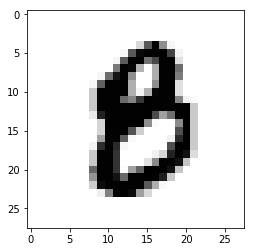

In [11]:
index = np.random.randint(0, test_inputs.shape[0])
plt.imshow(test_inputs [index - 1].reshape(28, 28), cmap="Greys", interpolation="None")

In [2]:
from keras.models import load_model
import time

def ensemble(models, inputs):
    prob = np.zeros((test_inputs.shape [0], 10))
    
    for model_path in models:  
        model = load_model(model_path)
        
        print("Evaluating with model", model_path)
        
        start = time.time()
        prob += model.predict(inputs)
        print("Finished in %.3f seconds" % (time.time() - start))
    
    return prob / len(models)

def list_models(folder):
    paths = [os.path.join(folder, file) for file in os.listdir(folder)]
    
    return [f for f in paths if os.path.isfile(f)]

Using TensorFlow backend.


In [12]:
prob = ensemble(list_models('models'), test_inputs)
labels = np.argmax(prob, axis=1)
 
submission = pd.DataFrame({"ImageId": list(range(1,len(labels)+1)), "Label": labels})
submission.to_csv("output.csv", index=False, header=True)

print("Submission saved!")

Evaluating with model models\mnist_11_acc_9930.h5
Finished in 35.062 seconds
Evaluating with model models\mnist_20_acc_9930.h5
Finished in 33.820 seconds
Evaluating with model models\mnist_3_acc_9926.h5
Finished in 33.952 seconds
Submission saved!
